In [2]:
import numpy as np
import os
import dill
script_dir = os.getcwd()


from sde.SDE_ARFF_lib import (
    SDEARFFTrain,
    NNHyperparameters
)

from sde.experiment_reports_owen import (
    PlotResults
)

%load_ext autoreload
%autoreload 2



In [3]:
# note book parameters
ex_name = "ex3-1D_cubic"
data_name = f"{ex_name}_time1_SS1e-05_ntraj100"

random_seed = 1
step_size = 0.01


In [4]:
# load true functions
with open(f"true_functions/{ex_name}.pkl", "rb") as f:
    true_functions = dill.load(f)

true_drift = true_functions["drift"]
true_diffusion = true_functions["diffusion"]

# load data
training_data = np.load(f"training_data/{data_name}.npz")

n_dimensions = training_data["n_dimensions"]
trajectory_step_size = training_data["step_size"]
xlim = training_data["xlim"]
trajectories = training_data["trajectories"]

In [5]:
# network parameters
validation_split = .1
ARFF_validation_split = .1

drift_param = NNHyperparameters(K=2**4, 
                                M_min=10,
                                M_max=100,
                                lambda_reg=2e-3,
                                gamma=1,
                                delta=0.1,
                                name='drift')
diff_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               lambda_reg=drift_param.lambda_reg,
                               gamma=drift_param.gamma,
                               delta=drift_param.delta,
                               name='diff')


step_size: 0.5
# data points: 200
drift epoch: 78


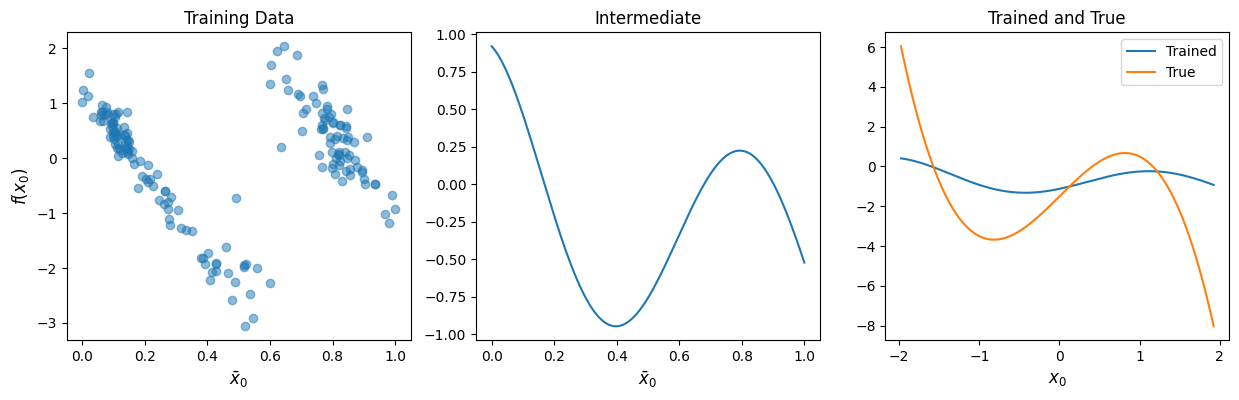

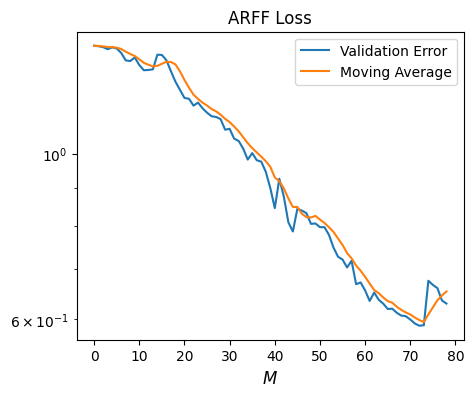

diff epoch: 20


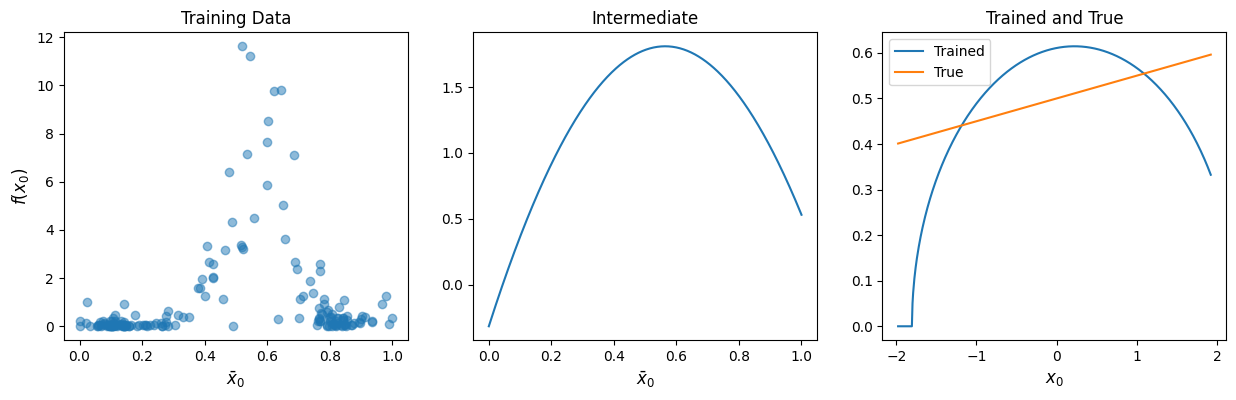

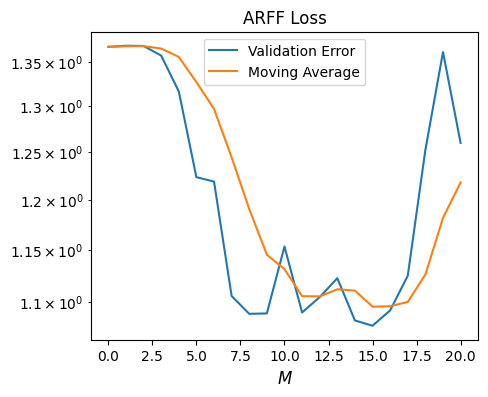

Drift RMSE: 1.7551336964738626
Diffusion RMSE: 0.12417240128780759
Observed loss: 7984.522597822427
Observed validation loss: 0.4974024488528075
True loss: 5.618127408946632
Training time: 0.14334678649902344
finish
step_size: 0.1
# data points: 900
drift epoch: 33


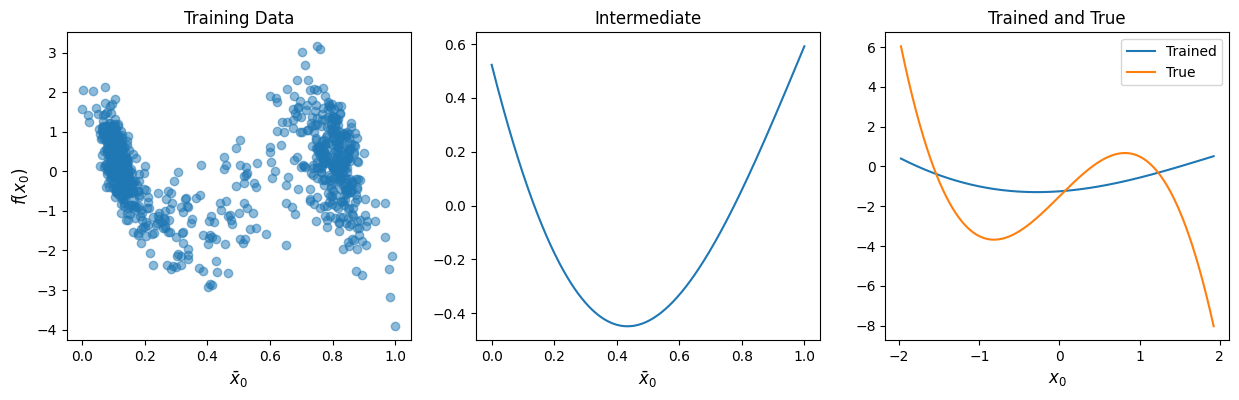

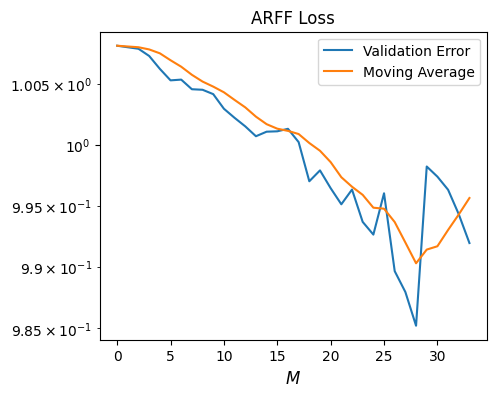

diff epoch: 21


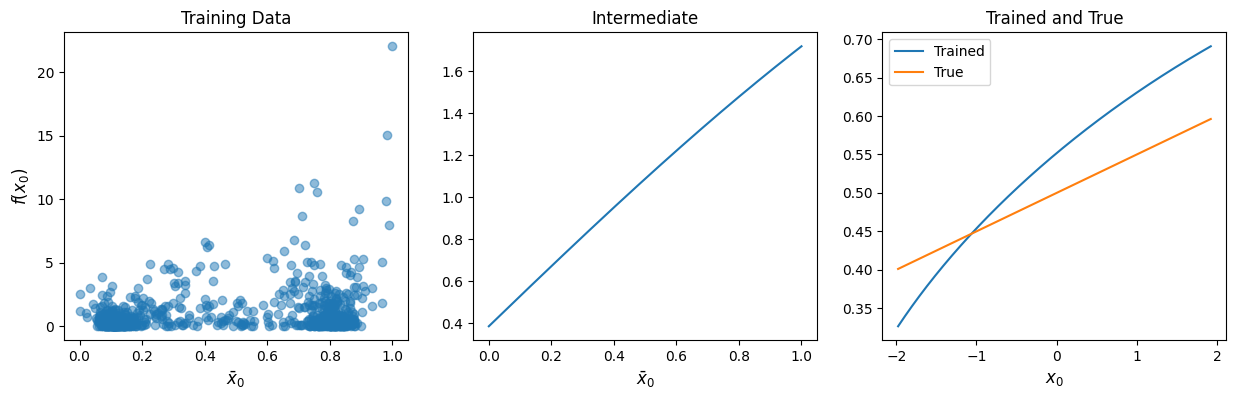

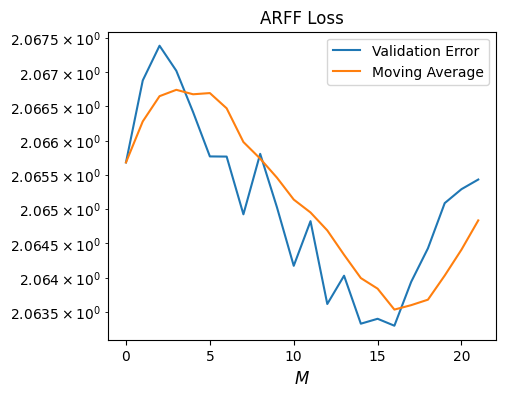

Drift RMSE: 1.4028904298180644
Diffusion RMSE: 0.06057691336203028
Observed loss: -0.43122593231031064
Observed validation loss: -0.32463545839448643
True loss: -0.5260865664330544
Training time: 0.11771011352539062
finish
step_size: 0.05
# data points: 1900
drift epoch: 22


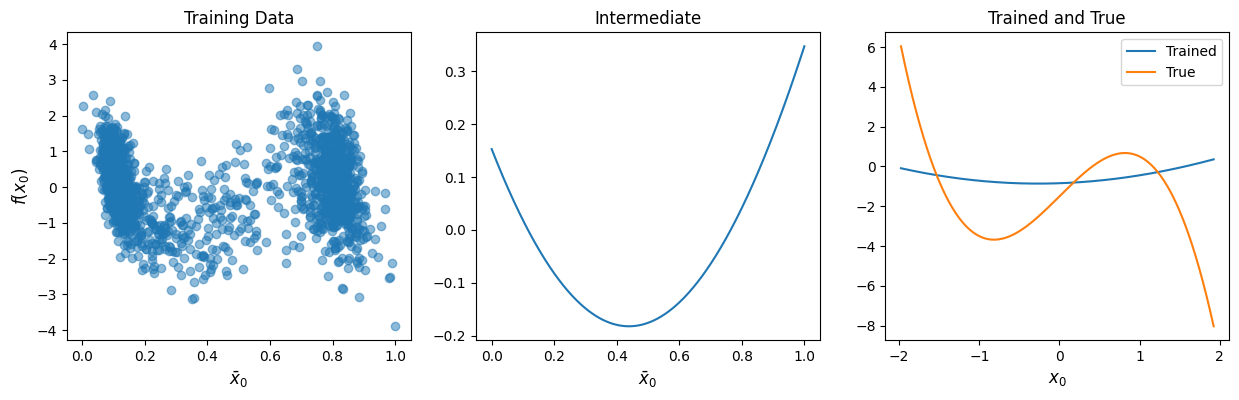

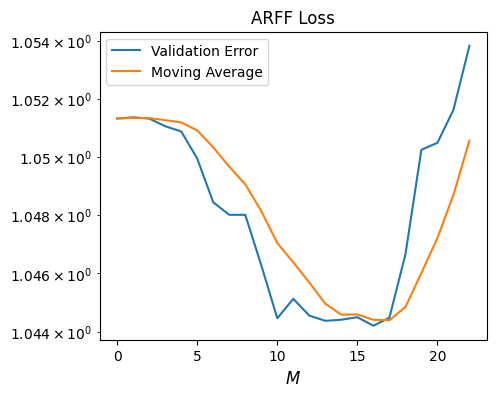

diff epoch: 86


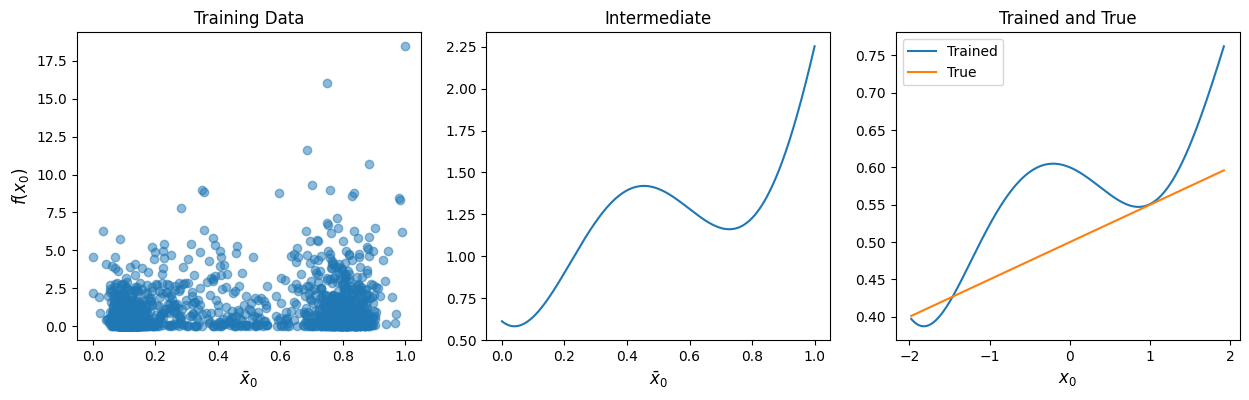

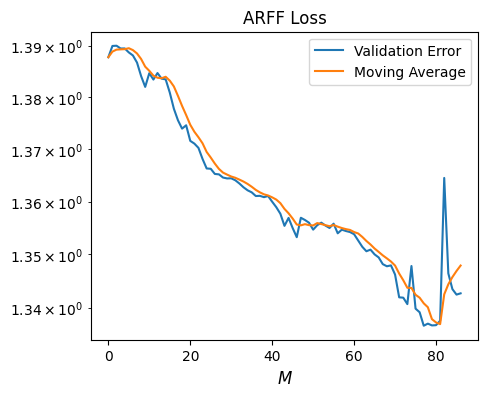

Drift RMSE: 1.347889970388998
Diffusion RMSE: 0.039891382739538545
Observed loss: -0.7921476656658728
Observed validation loss: -0.7447020938892415
True loss: -0.8992313989968256
Training time: 0.36699986457824707
finish
step_size: 0.01
# data points: 10000
drift epoch: 27


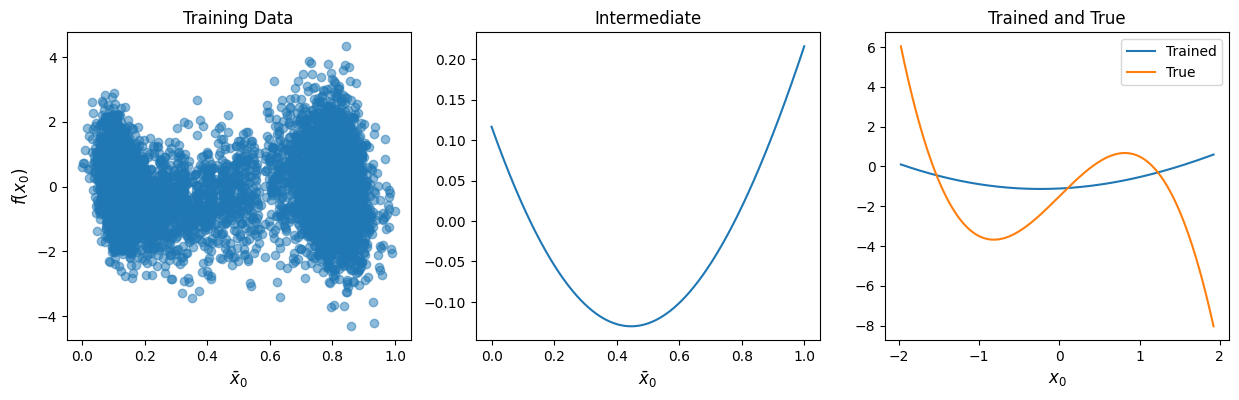

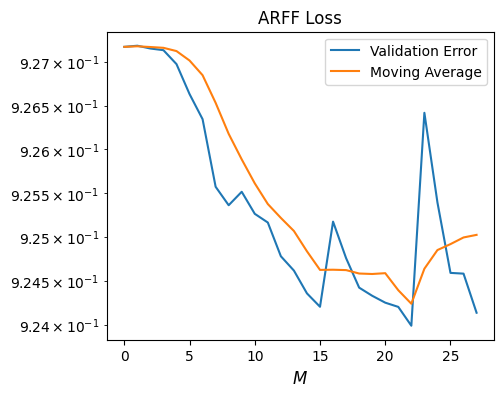

diff epoch: 10


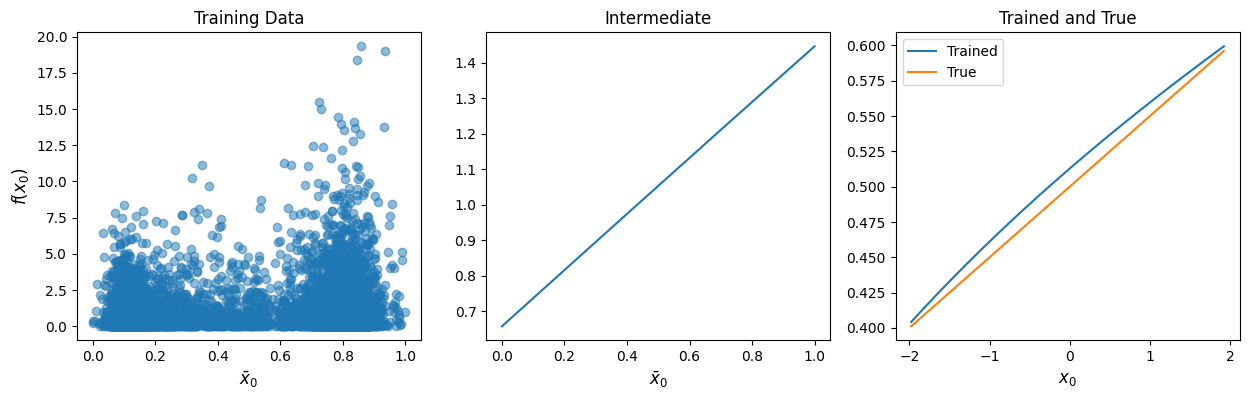

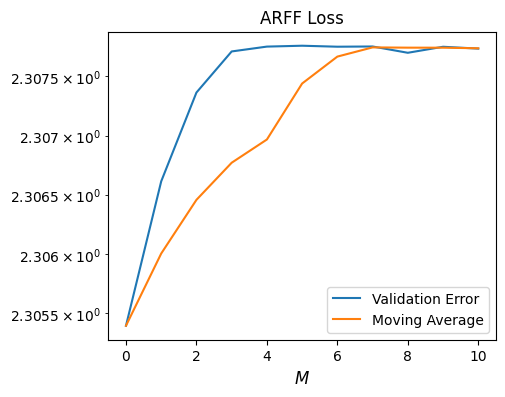

Drift RMSE: 1.2607929365203017
Diffusion RMSE: 0.008813455256251539
Observed loss: -1.600674427823672
Observed validation loss: -1.6310950621615947
True loss: -1.6526447707963152
Training time: 0.4763906002044678
finish
step_size: 0.005
# data points: 20000
drift epoch: 44


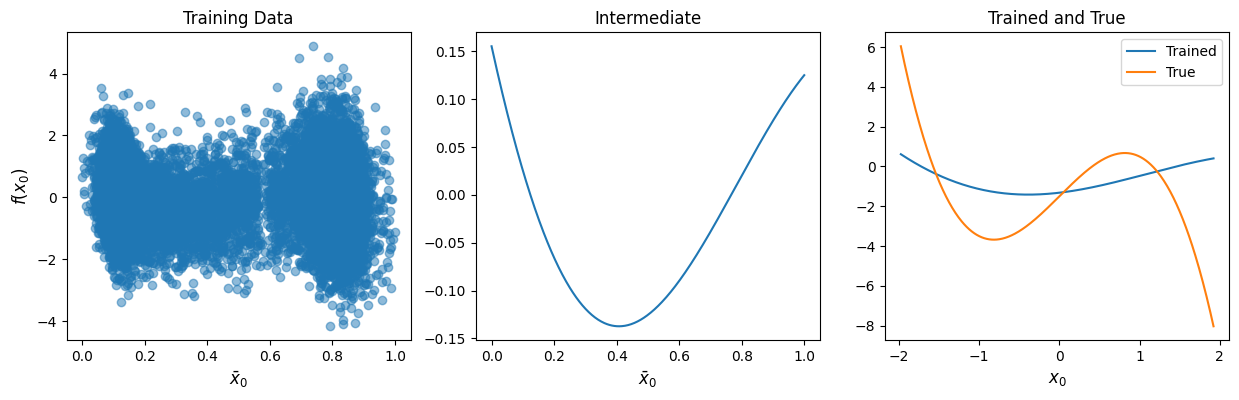

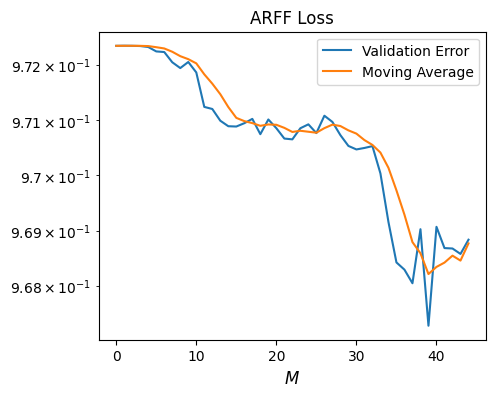

diff epoch: 13


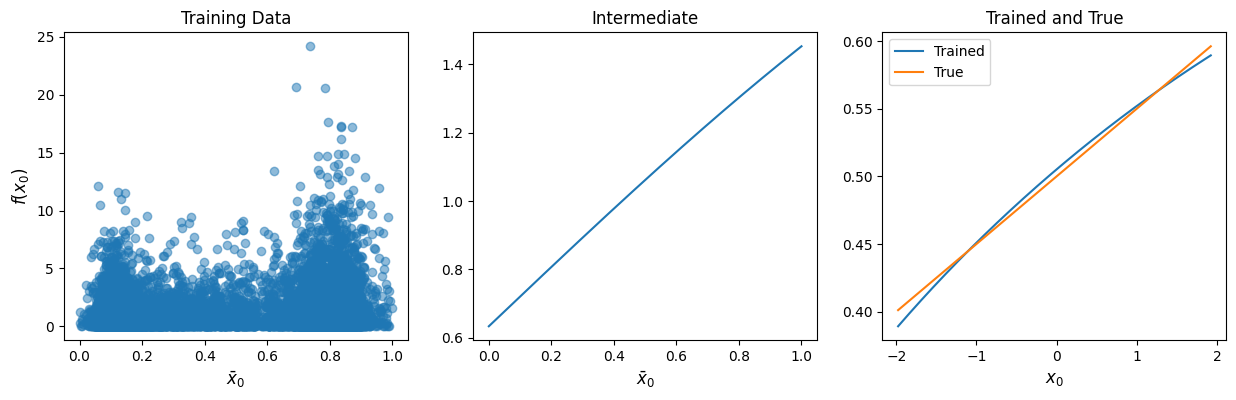

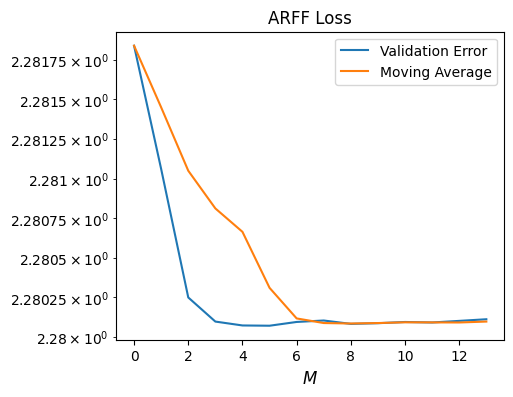

Drift RMSE: 1.1682890086980313
Diffusion RMSE: 0.0038798245118632315
Observed loss: -1.9647812981017059
Observed validation loss: -1.9595290211339516
True loss: -1.9450259139558996
Training time: 1.6379501819610596
finish
step_size: 0.001
# data points: 99900
drift epoch: 52


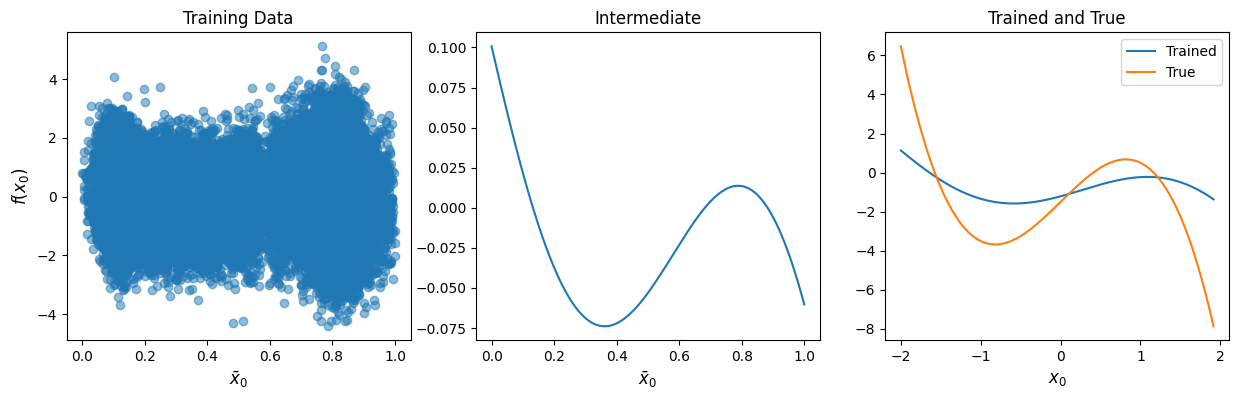

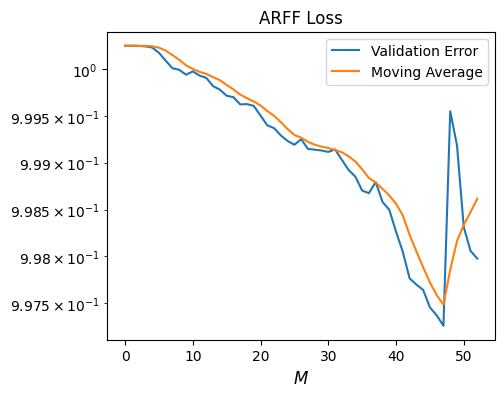

diff epoch: 16


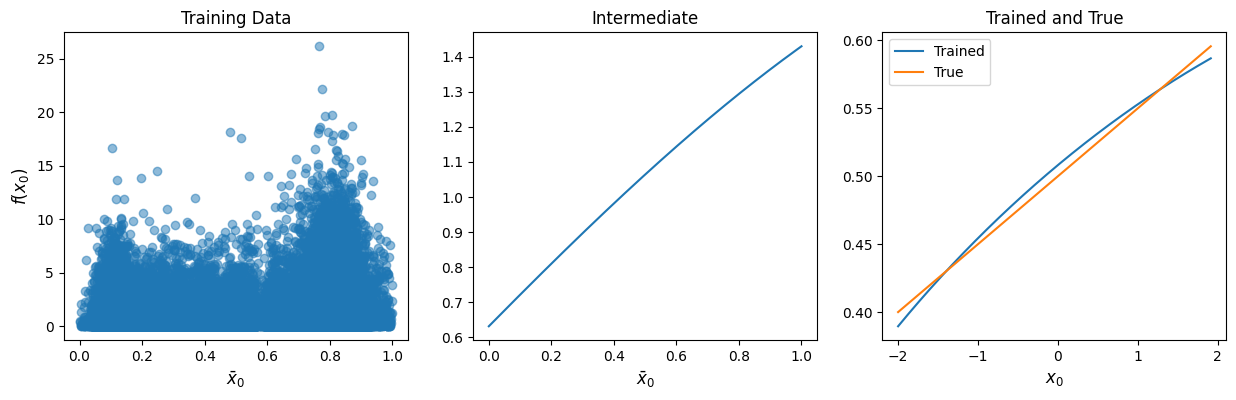

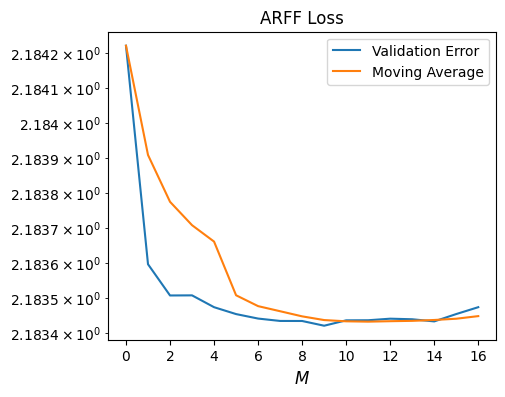

Drift RMSE: 0.9867083897587706
Diffusion RMSE: 0.003395024877747648
Observed loss: -2.764862007550321
Observed validation loss: -2.760296690091762
True loss: -2.7451450582715378
Training time: 9.728156805038452
finish
step_size: 0.0005
# data points: 199900
drift epoch: 64


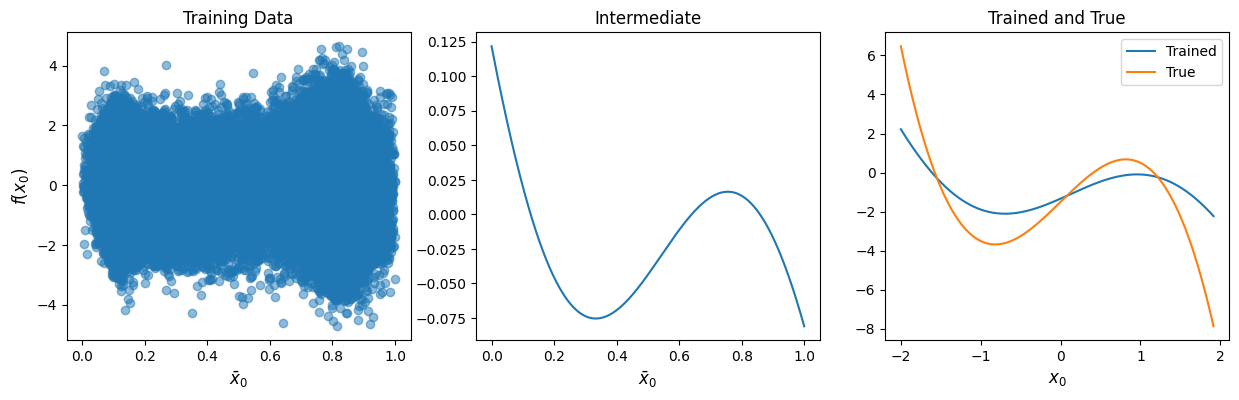

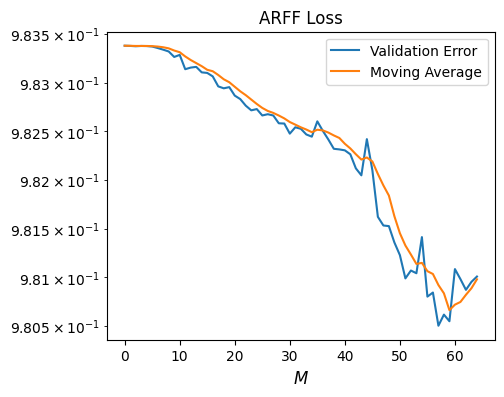

diff epoch: 10


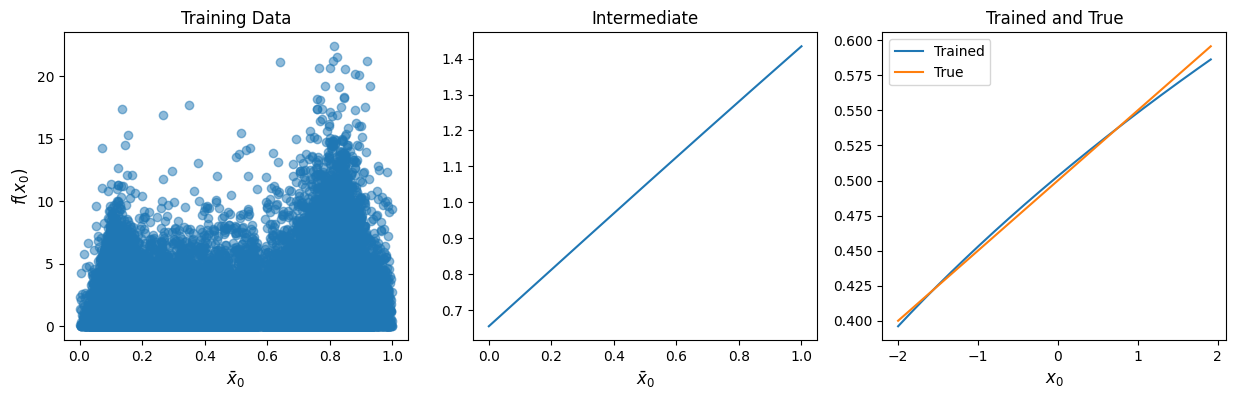

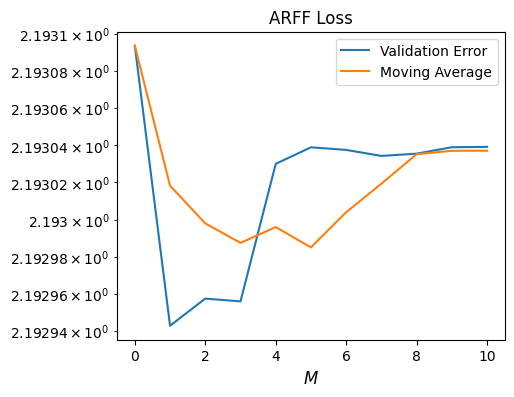

Drift RMSE: 0.7730251677363893
Diffusion RMSE: 0.0023724401697564007
Observed loss: -3.113515585603357
Observed validation loss: -3.1189344780693027
True loss: -3.102347376265644
Training time: 20.233641147613525
finish
step_size: 0.0001
# data points: 999900
drift epoch: 45


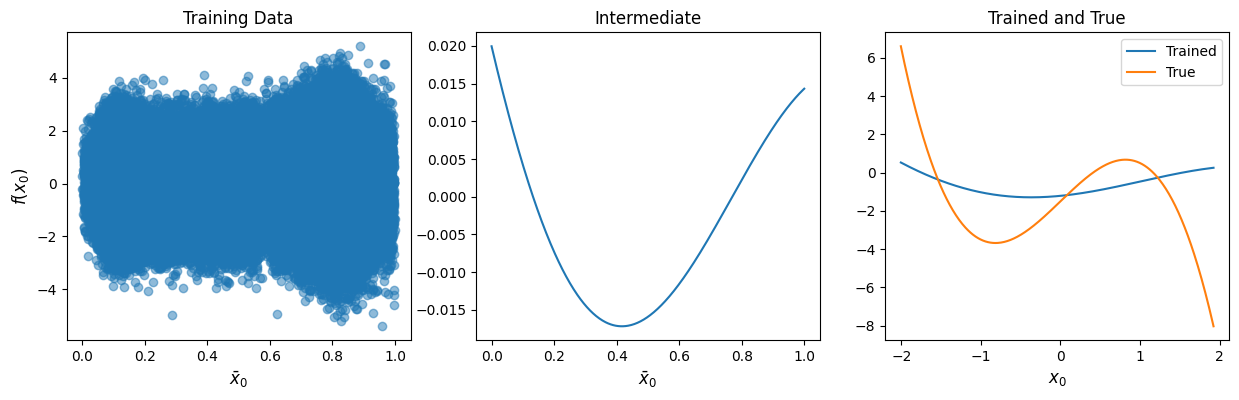

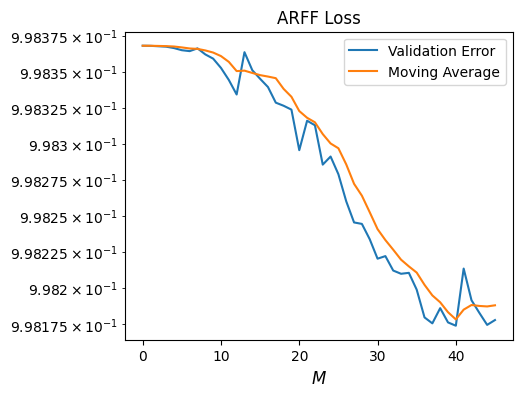

diff epoch: 10


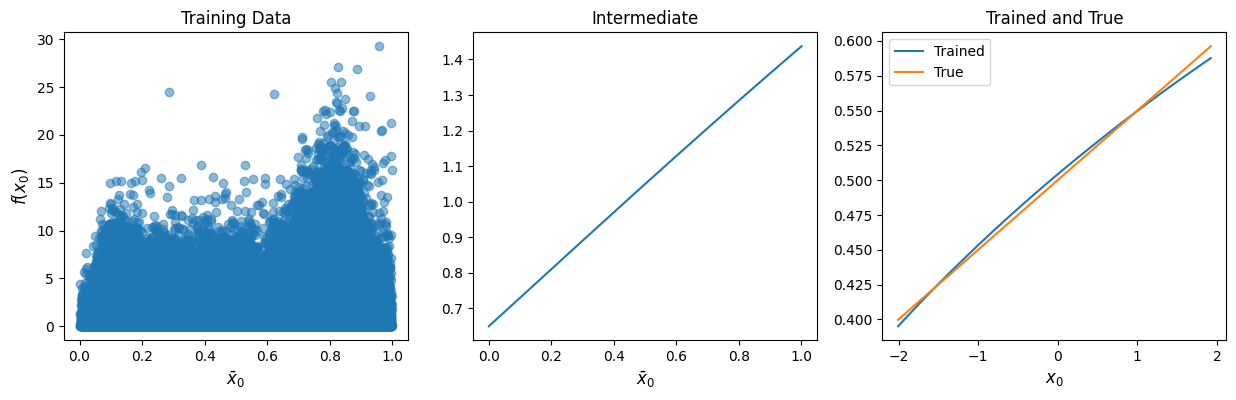

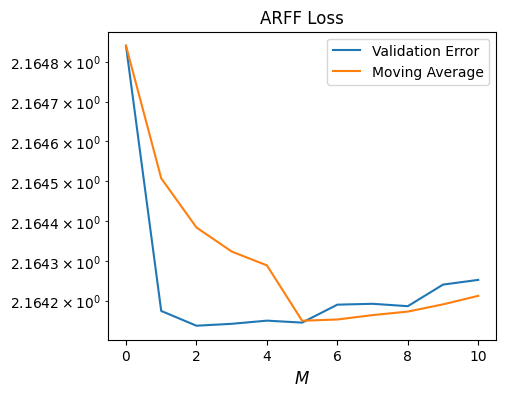

KeyboardInterrupt: 

In [6]:

# step_size_test = 10 ** np.linspace(-1, -4, 8)
step_size_test = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]

drift_RMSE = np.zeros(len(step_size_test))
diffusion_RMSE = np.zeros(len(step_size_test))

for j, step_size in enumerate(step_size_test):
    print('step_size:', step_size)
    rng = np.random.default_rng(random_seed)
    
    sampled_trajectories = trajectories[:, :, ::int(step_size/trajectory_step_size)]
    x_data = sampled_trajectories[:, :, :-1].reshape(-1, n_dimensions)
    y_data = sampled_trajectories[:, :, 1:].reshape(-1, n_dimensions)
    print('# data points:', x_data.shape[0])
    
    step_sizes = np.zeros((x_data.shape[0], 1)) + step_size
    
    # build network
    SAT = SDEARFFTrain(n_dimensions=n_dimensions, rng=rng, resampling=True)
    
    # train network
    hist = SAT.train_model(drift_param, diff_param, true_drift, true_diffusion, x_data, y_data, step_sizes=step_sizes, validation_split=validation_split, ARFF_validation_split=ARFF_validation_split, plot=True)
    print('finish')
    drift_RMSE[j] = hist.history["drift_RMSE"]
    diffusion_RMSE[j] = hist.history["diffusion_RMSE"]




In [ ]:
import matplotlib.pyplot as plt

plt.loglog(step_size_test, drift_RMSE)
plt.xlabel('step size')
plt.ylabel('drift RMSE')
plt.show()

plt.loglog(step_size_test, diffusion_RMSE)
plt.xlabel('step size')
plt.ylabel('diffusion RMSE')
plt.show()



In [ ]:
# save
output_dir = os.path.join(script_dir, 'saved_results', 'RMSE_v_step_size_v_K_data')
output_file = os.path.join(output_dir, f"{ex_name}_K{drift_param.K}.npz")
np.savez(output_file, step_size=step_size_test, drift_RMSE=drift_RMSE, diffusion_RMSE=diffusion_RMSE)
